In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
#!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/](https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Prices&rdquo;, and a series of different years of food &ldquo;Expenditures&rdquo;.

Each worksheet has the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should
have one column for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Ugandan example that I wish to work
through.



In [2]:
Uganda_Data = '1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Uganda_Data,sheet='Expenditures (2019-20)')
x.columns.name = 'j'

p = read_sheets(Uganda_Data,sheet='Prices').set_index(['t','m'])
p.columns.name = 'j'
p = p.xs('2019-20',level='t')

d = read_sheets(Uganda_Data,sheet="HH Characteristics")
d.columns.name = 'k'

# x may have duplicate columns
x = x.T.groupby('j').sum().T
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

d.set_index(['i','t','m'],inplace=True)

/tmp/ipykernel_10553/3389232646.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = x.replace(0,np.nan) # Replace zeros with missing


This gives a dataframe of household characteristics $d$ with a simple structure.



In [4]:
d.head()

k                                                 F 00-03  F 04-08  F 09-13  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0      0.0      1.0   
                                 2019-20 Eastern      1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      1.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      1.0      1.0   

k                                                 F 14-18  F 19-30  F 31-50  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              3.0      1.0      0.0   
                                 2019-20 Eastern      3.0      1.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      1.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      1.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      0.0      1.0   

k                                                 F 51+  M 00-03  M 04-08  \
i                                t       m                                  
00c9353d8ebe42faabf5919b81d7fae7 2018-19            1.0      0.0      0.0   
                                 2019-20 Eastern    1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19            0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19            0.0      0.0      2.0   
039a11571b874a88b7a6c200469fe4f3 2018-19            0.0      0.0      0.0   

k                                                 M 09-13  M 14-18  M 19-30  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0      0.0      0.0   
                                 2019-20 Eastern      1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0      0.0      0.0   

k                                                 M 31-50  M 51+  log HSize  
i                                t       m                                   
00c9353d8ebe42faabf5919b81d7fae7 2018-19              0.0    0.0   2.079442  
                                 2019-20 Eastern      0.0    0.0   1.945910  
02dd448165ce46279ca601a02865d543 2018-19              0.0    0.0   0.000000  
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0    1.0   1.609438  
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0    0.0   1.609438

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
y.head()

,,j,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,8.188689,NaN,NaN,NaN,NaN,NaN,NaN,7.244228,NaN,8.699515,...,NaN,NaN,8.294050,5.298317,6.907755,NaN,NaN,NaN,8.006368,NaN
062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,6.907755,8.411833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.294050,...,NaN,NaN,NaN,NaN,6.684612,NaN,NaN,NaN,NaN,NaN
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,7.937375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.070906,...,NaN,NaN,8.517193,5.298317,6.214608,NaN,NaN,NaN,NaN,NaN
1013000201,2019-20,Central,NaN,NaN,9.769956,NaN,NaN,NaN,NaN,NaN,NaN,8.294050,...,NaN,7.600902,NaN,5.991465,7.649693,NaN,NaN,NaN,NaN,NaN


## Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
So, a first step is to turn our dataframe for `y` into a series, so we can put it on the left-hand side of this regression.  Then we need to make our dataframe $d$ conform:



In [6]:
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

### Basic Estimation



Just one line to set up the regression:



In [7]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [8]:
result.predicted_expenditures()

i                                 t        m         j             
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern   Beans             3734.056145
                                                     Beef              9831.715556
                                                     Biscuits          1312.459857
                                                     Bread             3780.272722
                                                     Cabbages          1250.071808
                                                                          ...     
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern  Sweet Bananas     2513.237637
                                                     Sweet Potatoes    7513.732200
                                                     Tea                207.521279
                                                     Tomatoes          1410.956143
                                                     Waragi            4469.686843
Length: 94325, dtyp

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

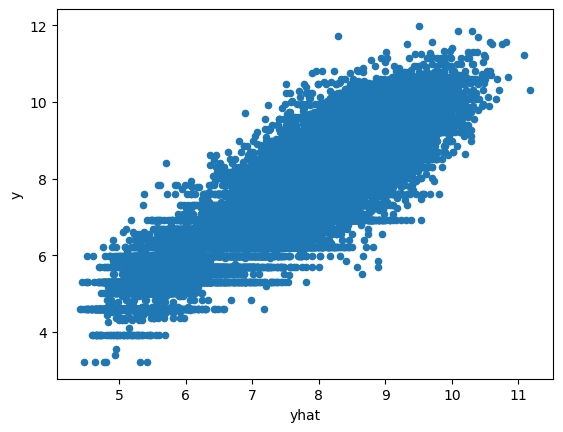

In [9]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



### Parameters



#### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



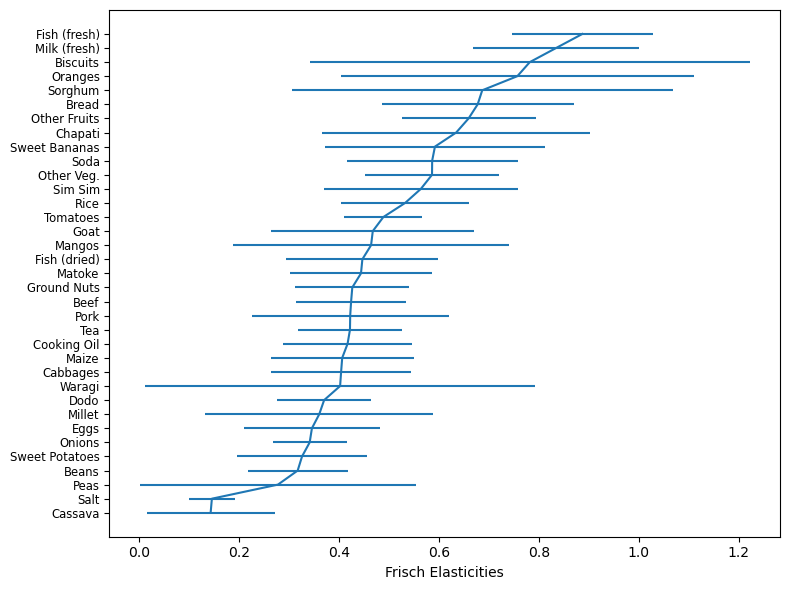

In [10]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [11]:
result.get_beta()

j
Beans             0.316913
Beef              0.423841
Biscuits          0.781522
Bread             0.677132
Cabbages          0.403810
Cassava           0.142661
Chapati           0.634176
Cooking Oil       0.416759
Dodo              0.369812
Eggs              0.345383
Fish (dried)      0.446381
Fish (fresh)      0.886778
Goat              0.467223
Ground Nuts       0.426204
Maize             0.406007
Mangos            0.463788
Matoke            0.443616
Milk (fresh)      0.834115
Millet            0.360086
Onions            0.340940
Oranges           0.756571
Other Fruits      0.658992
Other Veg.        0.585797
Peas              0.277380
Pork              0.422006
Rice              0.531964
Salt              0.145142
Sim Sim           0.563487
Soda              0.586076
Sorghum           0.686320
Sweet Bananas     0.591652
Sweet Potatoes    0.325598
Tea               0.421568
Tomatoes          0.488395
Waragi            0.401824
Name: beta, dtype: float64

#### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [12]:
result.get_gamma()

k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,log HSize,Constant
j,,,,,,,,,,,,,,,,
Beans,-0.129845,0.024727,0.064567,-0.028448,-0.002598,0.029310,0.084417,-0.071322,0.020194,0.036715,0.049218,0.042955,0.011466,0.107460,0.426698,8.409504
Beef,-0.121810,0.046408,0.033906,0.022340,0.084701,0.093669,0.222188,-0.008614,0.026050,0.016648,0.055342,0.080857,0.196879,0.148855,0.122587,9.262532
Biscuits,-0.068814,-0.131646,-0.041326,0.101954,-0.122081,0.295563,0.287443,0.270660,-0.033024,-0.136711,-0.181973,-0.019032,-0.115969,-0.374188,0.279835,6.792856
Bread,-0.015413,0.046979,-0.053303,0.016995,0.054328,0.073295,0.134078,-0.061955,0.100468,0.014863,0.043759,0.054900,0.172740,0.106329,0.212862,8.285099
Cabbages,0.000047,-0.052952,0.034075,0.024258,-0.010929,0.031573,0.057126,-0.049127,0.035070,0.004137,0.052812,0.084709,0.018162,0.054391,0.203897,7.044567
Cassava,0.024785,0.087112,0.099496,0.046304,0.021227,0.049439,0.138227,0.008328,0.137877,0.190429,0.158452,0.067733,0.103726,0.134321,0.157361,8.437182
Chapati,-0.060105,-0.020808,0.063681,0.090755,-0.024146,0.013664,-0.073183,0.000267,0.047077,-0.045219,-0.043024,0.076034,0.138217,0.134401,0.209899,7.644030
Cooking Oil,-0.088183,-0.049166,-0.050817,0.017481,0.005940,-0.005681,-0.081625,-0.112399,-0.077558,-0.039460,-0.007269,-0.042908,-0.006277,0.036738,0.419226,7.262257
Dodo,-0.068655,0.003535,0.112343,0.053806,0.044161,0.075993,0.195738,-0.022117,0.035598,0.080625,0.009036,0.032212,0.084695,0.194343,0.140041,7.233421


#### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

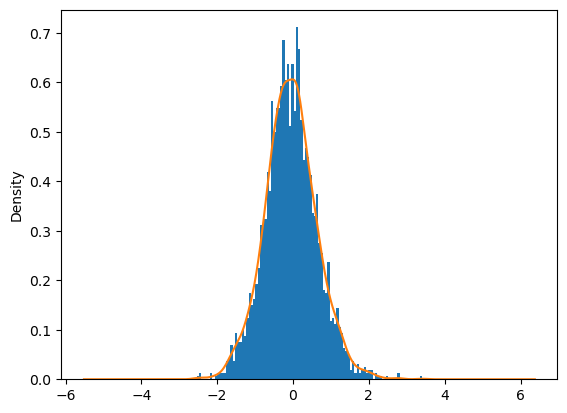

In [13]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

### Saving Result



You can save the estimated result, using something like



In [14]:
result.to_pickle('uganda_estimates.rgsn')

You can subsequently load this using



In [15]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')

### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



#### Budgets



Get food budget for all households, then find median budget:



In [16]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [17]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

#### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



Text(0.5, 0, 'Quantities of Millet Demanded')

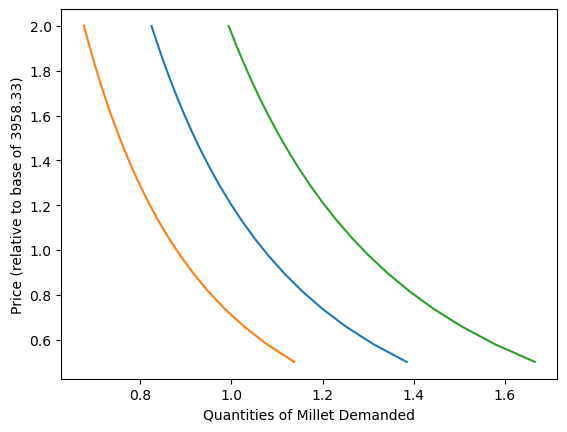

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



Engel curves trace out how demand changes with budget:



Text(0.5, 1.0, 'Engel Curves')

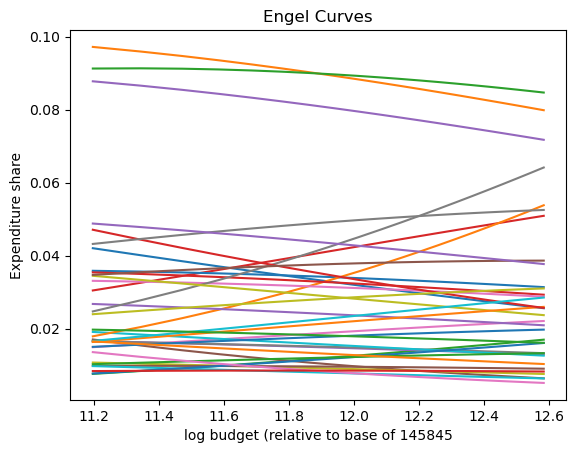

In [19]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

#### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



Text(0.5, 1.0, 'Indirect Utility Function')

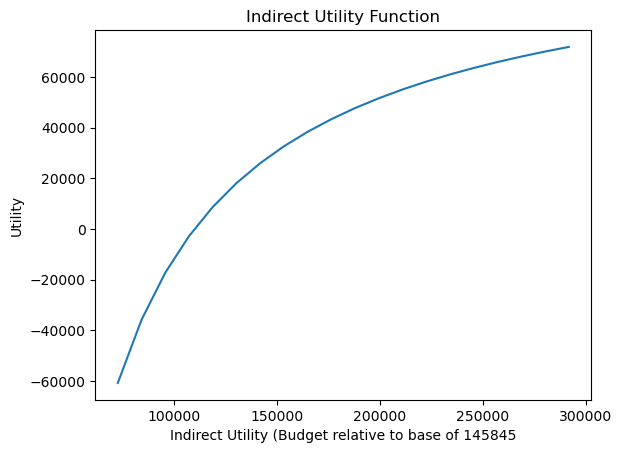

In [20]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')